
# Introduction
This dataset is taken from https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset and it contains information on 30,000 credit card holders from a bank in Taiwan. Each credit card holder is described by 23 feature attributes as outlined below.

## Data Modelling Problem
We aim to predict whether a credit card holder will be defauting his payment in the next month.

## Feature Descriptions

**Client info**

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years

**Payment**
*(-2 = No consumption; -1 = Paid in full; 0 = The use of revolving credit (Customer paid amount due, but not all); 1 = payment delay for one month; 2 = payment delay for two months;...; 8 = payment delay for eight months; 9 = payment delay for nine months and above.)*
https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

- PAY_0: Repayment status in September, 2005
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)

**Bill Statement**
*(Possible to have negative values --> Overpayment)*

- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

**Previous Payment**

- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

**Target Variable**

- default.payment.next.month: Default payment (1=yes, 0=no)

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import chi2, SelectKBest
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import tensorflow as tf
from scikeras.wrappers import KerasClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

# Exploratory Data Analysis

In [2]:
data = pd.read_csv("./card.csv", index_col=0, header=1)

data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

In [4]:
data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


From the output above, we observe that there are no missing data entries in the dataset, however, there are potential outliers that will have to be cleaned later on.

In [5]:
## Renaming Target Variable Column
data.rename(columns={"default payment next month": "default"}, inplace=True)

In [6]:
## Renaming "PAY_0" to "PAY_1" for consistency
data.rename(columns={"PAY_0" : "PAY_1"}, inplace=True)

## Analysis of the Target Variable (Default)

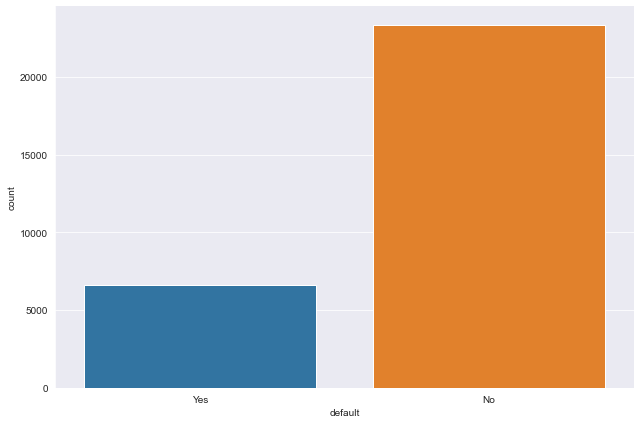

In [7]:
default = data[["default"]]
default = default.replace({1:"Yes", 0:"No"})
sns.catplot(data=default, x="default", height=6, aspect=1.5, kind="count")

We observe that the number of defaulters is significantly lesser than the amount of non defaulters in the given dataset

## Analysis of amount of given credit (LIMIT_BAL)

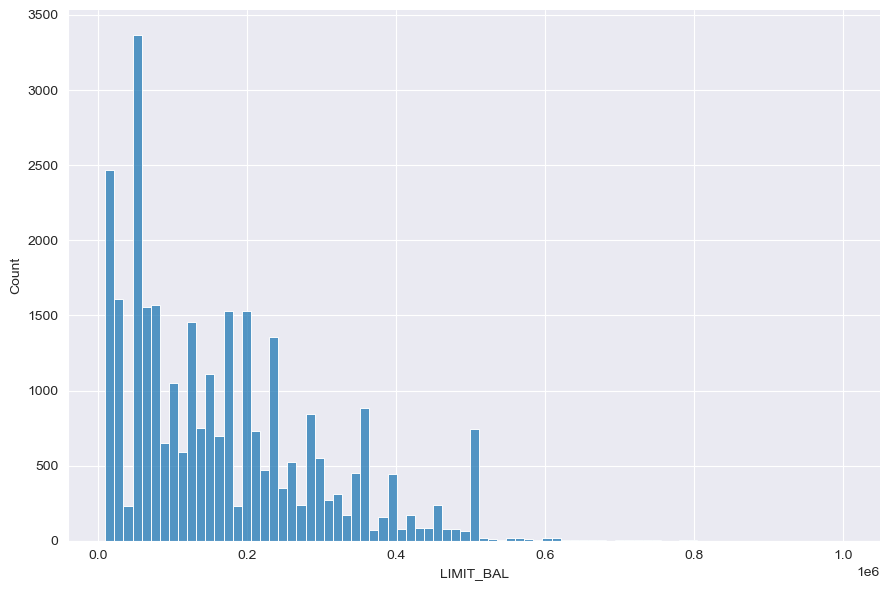

In [8]:
sns.displot(data=data, x="LIMIT_BAL", height=6, aspect=1.5)

The amount of credit given to card-holders is not normally distributed. It is right skewed.

## Analysis on SEX

In [9]:
sex = data["SEX"].replace({1:"Male", 2:"Female"})
sex.value_counts()

Female    18112
Male      11888
Name: SEX, dtype: int64

In [10]:
sex = sex.reset_index()

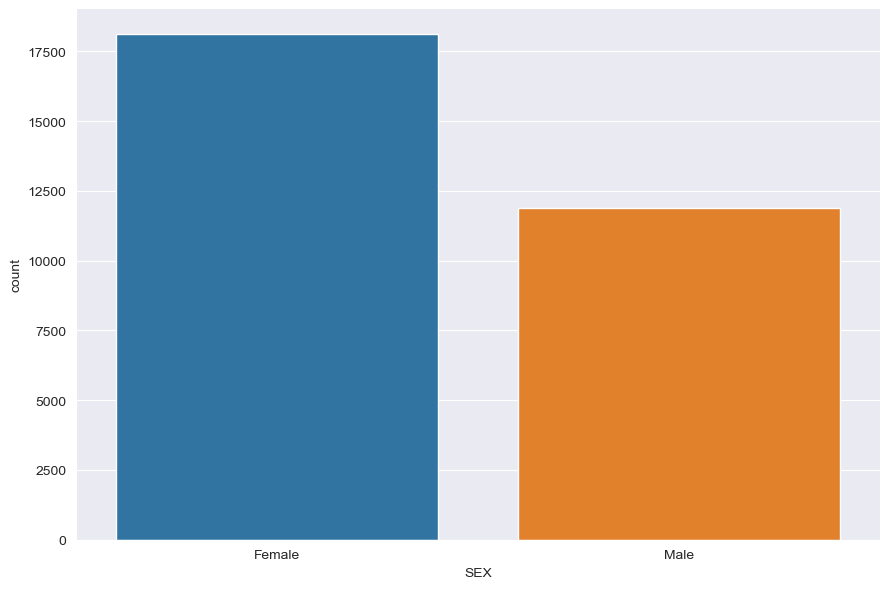

In [11]:
sns.catplot(data=sex, x="SEX", kind="count", height=6, aspect=1.5)

In [12]:
# convert the "SEX" column to map 0=male, 1=female instead of 1=male, 2=female
data["SEX"] = data["SEX"] - 1
data["SEX"].value_counts()

1    18112
0    11888
Name: SEX, dtype: int64

## Analysis on Education

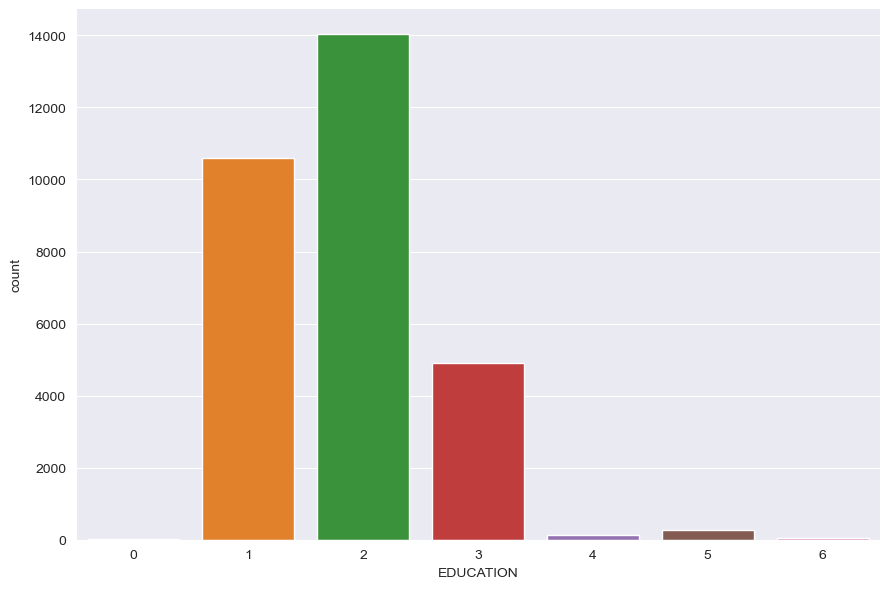

In [13]:
sns.catplot(data=data, kind="count", x="EDUCATION", height=6, aspect=1.5)

In [14]:
# We observe additional EDUCATION categories (0, 5, 6)
# We will convert them to others (4)
data["EDUCATION"] = data["EDUCATION"].replace({0:4, 5:4, 6:4})
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

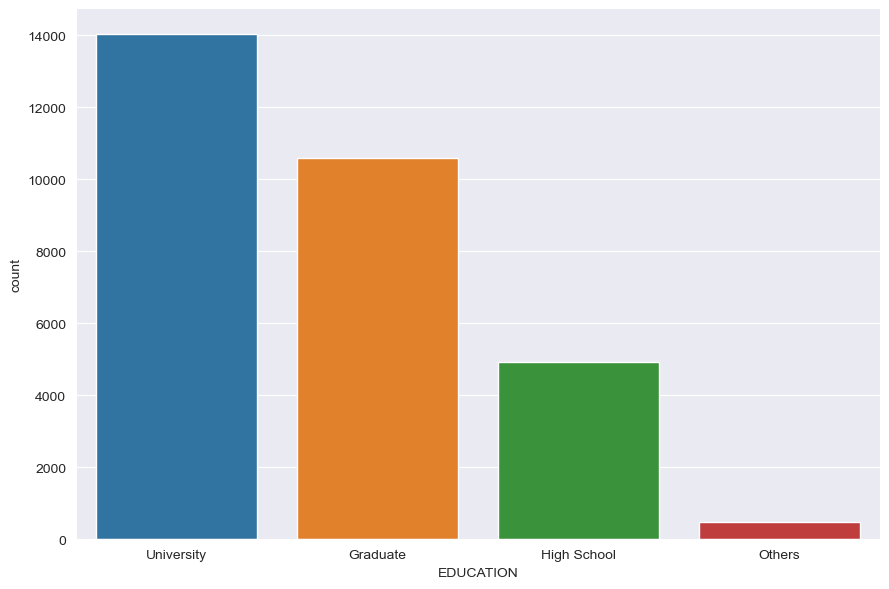

In [15]:
education = data[["EDUCATION"]].replace({1:"Graduate", 2:"University", 3:"High School", 4:"Others"})
sns.catplot(data=education, kind="count", x="EDUCATION", height=6, aspect=1.5)

## Analysis of Marriage

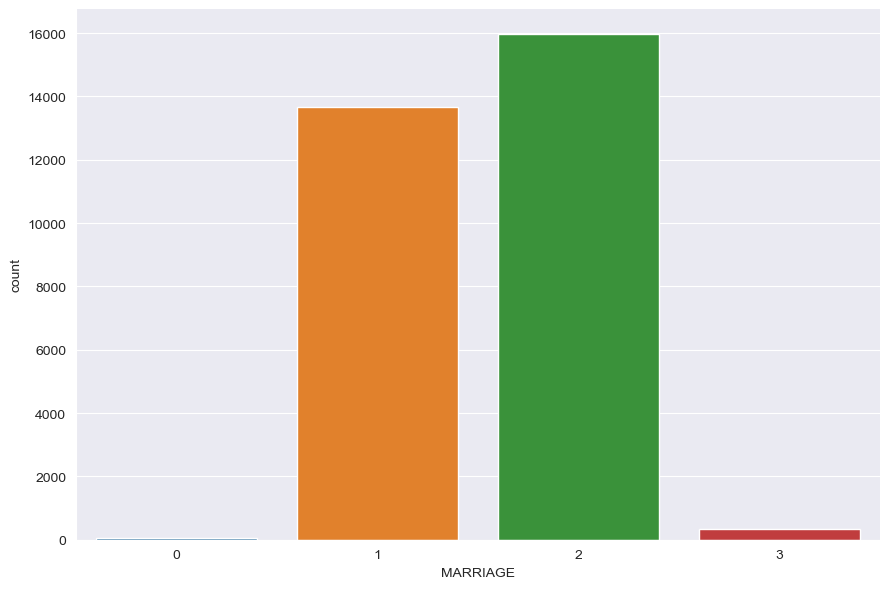

In [16]:
sns.catplot(data=data, kind="count", x="MARRIAGE", height=6, aspect=1.5)

In [17]:
# 0 value for marriage will be converted to 3 (others)
data["MARRIAGE"] = data["MARRIAGE"].replace({0:3})
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

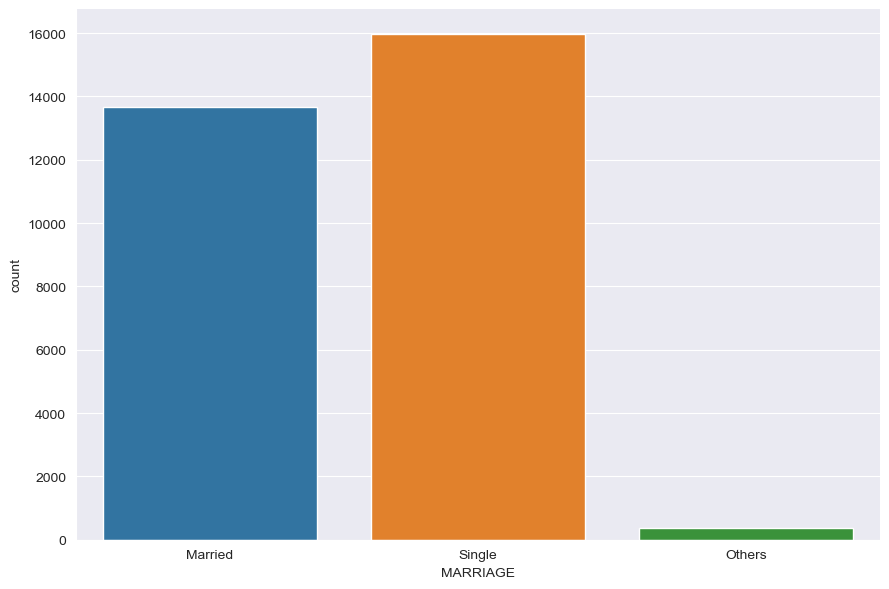

In [18]:
marriage = data[["MARRIAGE"]].replace({1:"Married", 2:"Single", 3:"Others"})
sns.catplot(data=marriage, kind="count", x="MARRIAGE", height=6, aspect=1.5)

## Analysis of Age

In [19]:
data["AGE"].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

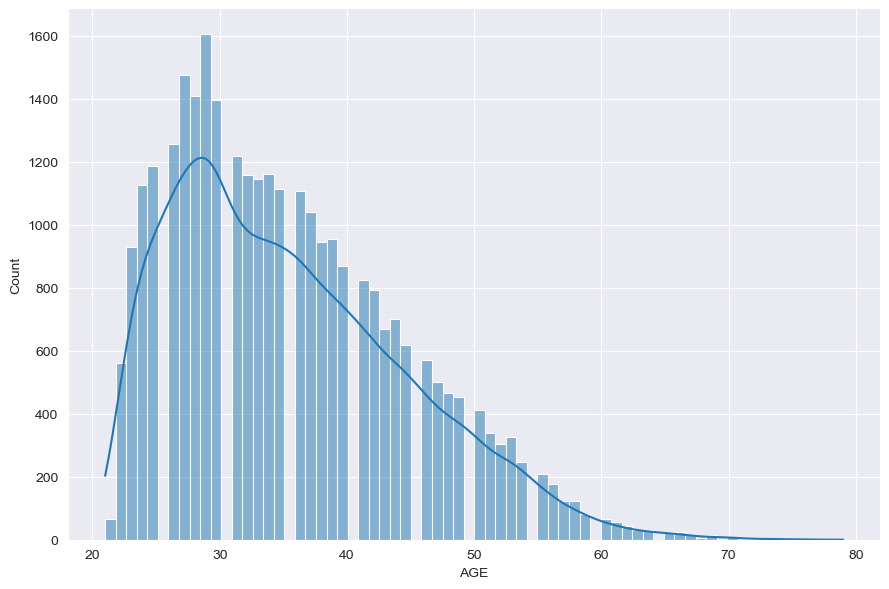

In [20]:
# Age distribution looks approximately normally distributed
sns.displot(data = data, x = "AGE", height=6, aspect=1.5, kde=True)

## Investigating relationship between Limit Balance and Default

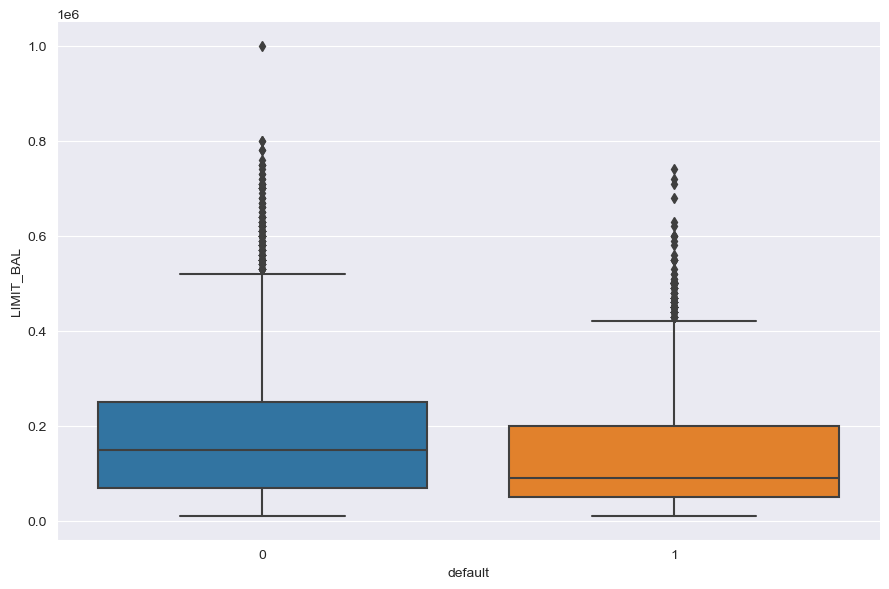

In [21]:
sns.catplot(data=data, x="default", y="LIMIT_BAL", kind="box", height=6, aspect=1.5)

We had expected defaulters to have been given a higher credit, but the boxplot does not seem to show such a relationship

## Investigating relationship between AGE and Default

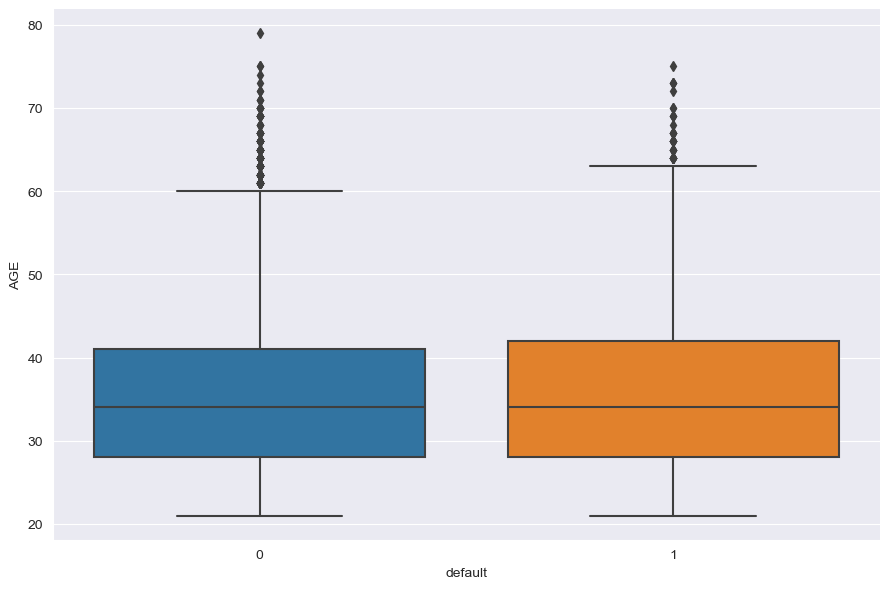

In [22]:
sns.catplot(data=data, y="AGE", x="default", kind="box", height=6, aspect=1.5)

Whether a person defaults on his payment or not does not seem to be influenced by a person's age

## Investigating relationship between Sex and Defaults

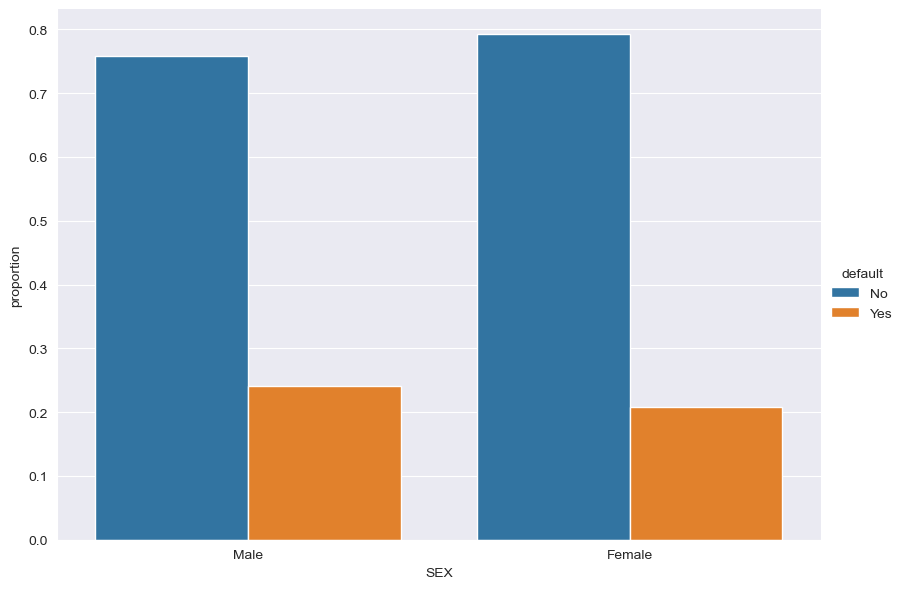

In [23]:
# creating proportions
sex_default = data["default"].groupby(data["SEX"]).value_counts(normalize=True).rename("proportion").reset_index()

# renaming
sex_default["SEX"] = sex_default[["SEX"]].replace({0:"Male", 1:"Female"})
sex_default["default"] = sex_default[["default"]].replace({0:"No", 1:"Yes"})

# plotting
sns.catplot(data=sex_default, x="SEX", y="proportion", kind="bar", hue="default", height=6, aspect = 1.4)

## Stacked
# sex_default.pivot(index="SEX", columns = ["default"], values="proportion").plot(kind='bar', stacked=True, color=['steelblue', 'red'])

It would appear from the barplot, that a larger proportion of males (1) default as compared to females (2).

## Investigating relationship between Education and Default

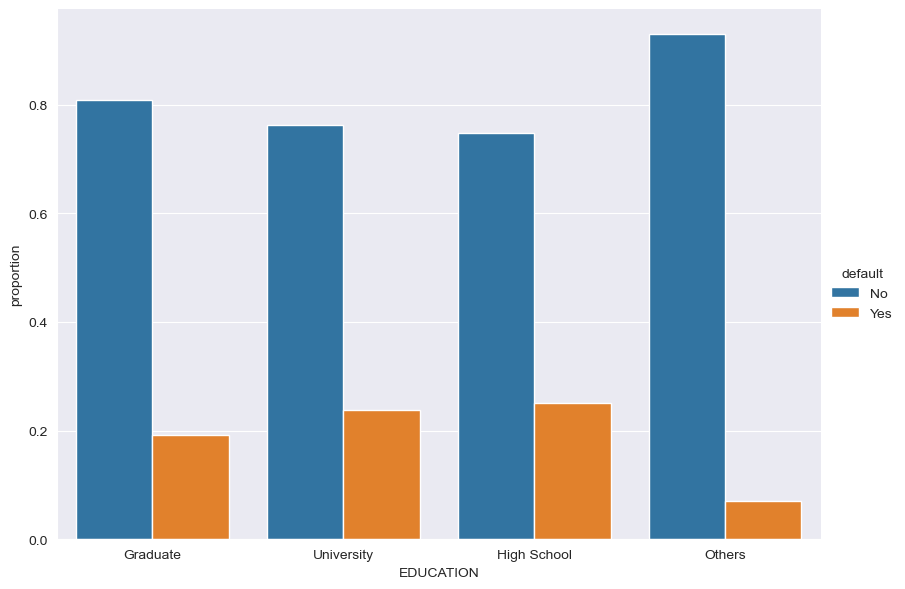

In [24]:
# creating proportions
edu_default = data["default"].groupby(data["EDUCATION"]).value_counts(normalize=True).rename("proportion").reset_index()

# renaming
edu_default["EDUCATION"] = edu_default[["EDUCATION"]].replace({1:"Graduate", 2:"University", 3:"High School", 4:"Others"})
edu_default["default"] = edu_default[["default"]].replace({0:"No", 1:"Yes"})

# plotting
sns.catplot(data=edu_default, x="EDUCATION", y="proportion", kind="bar", hue="default", height=6, aspect = 1.4)

From the proportion barplot as shown above, there is a higher proportion of people who are defaulting if their education levels is 2 (university), 3 (high school),
compared to those who have education levels of 1 (graduate school) or 4 (others).

## Investigating relationship between Marital Status and Default

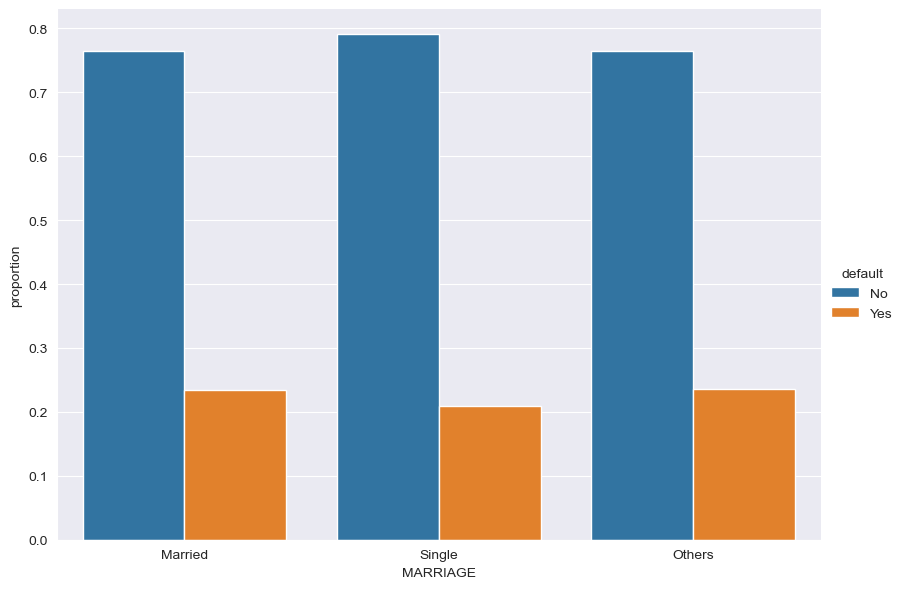

In [25]:
# creating proportions
marriage_default = data["default"].groupby(data["MARRIAGE"]).value_counts(normalize=True).rename("proportion").reset_index()

# renaming
marriage_default["MARRIAGE"] = marriage_default["MARRIAGE"].replace({3: "Others", 2:"Single", 1:"Married"})
marriage_default["default"] = marriage_default["default"].replace({1: "Yes", 0: "No"})

# plotting
sns.catplot(data=marriage_default, x="MARRIAGE", y="proportion", kind="bar", hue="default", height=6, aspect = 1.4);

From the proportion barplots as shown above, it would seem that people who are married (1) are more likely to default on their payments as compared to those who are single.

## Analysis on Repayment Status for 6 months, from April - September 2005

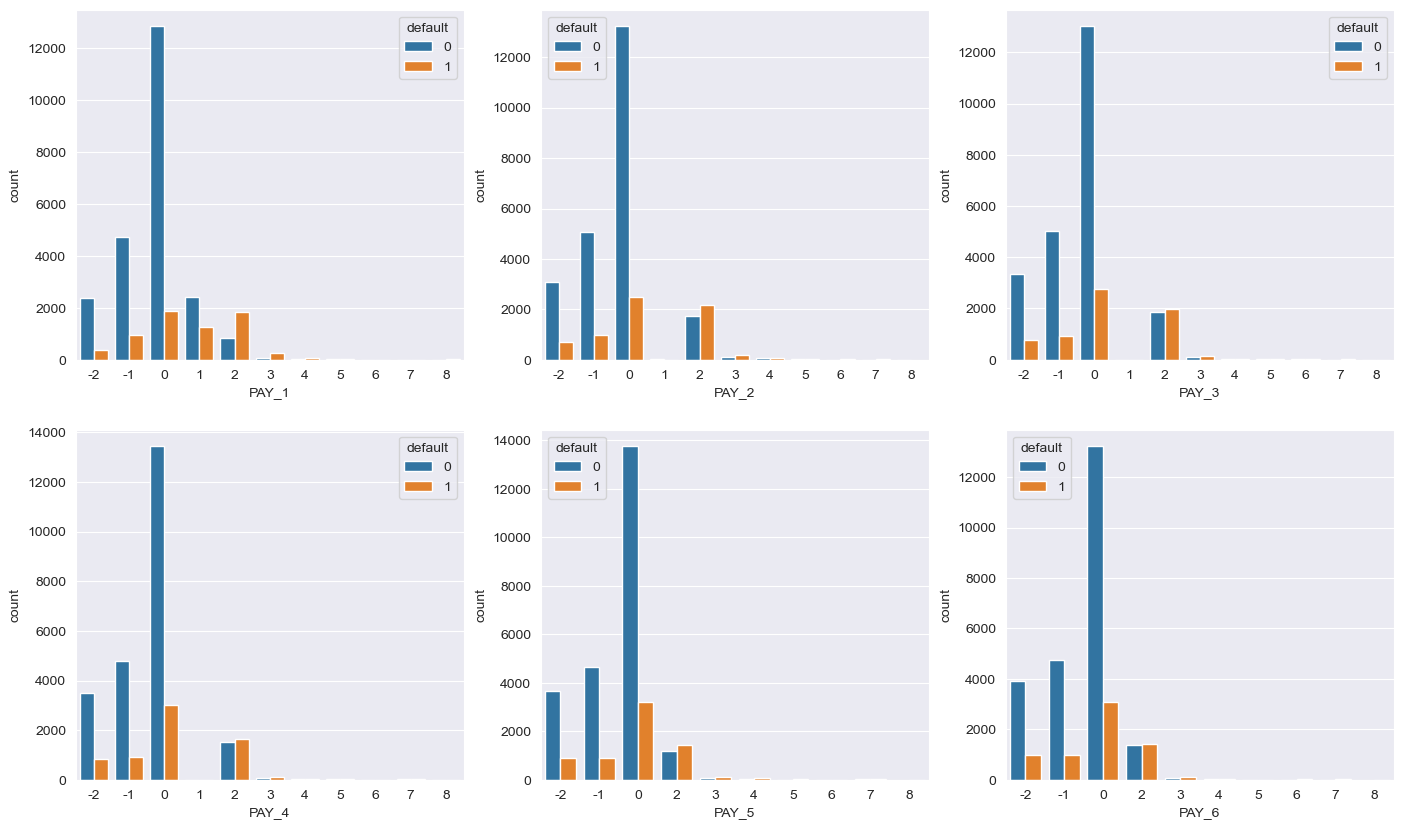

In [26]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.countplot(x = "PAY_1", hue = "default", data = data, ax = ax[0, 0])
sns.countplot(x = "PAY_2", hue = "default", data = data, ax = ax[0, 1])
sns.countplot(x = "PAY_3", hue = "default", data = data, ax = ax[0, 2])
sns.countplot(x = "PAY_4", hue = "default", data = data, ax = ax[1, 0])
sns.countplot(x = "PAY_5", hue = "default", data = data, ax = ax[1, 1])
sns.countplot(x = "PAY_6", hue = "default", data = data, ax = ax[1, 2])
plt.show()

Majority of non-defaulters pay on time indicated by the 0 value. However, we can observe that those who pay late are more likely to be defaulters (orange bar is larger than blue bar). As such, we will merge payments that are 1, 2 ... 8 as late, indicated by 1, and payments that are on time , -2, -1, 0, as on time, indicated by 0.

In [27]:
columns = ["PAY_1","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]

for column in columns:
    data[column] = data[column].apply(lambda x: 0 if x <= 0 else 1)

data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,1,2,1,24,1,1,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,1,2,2,26,0,1,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,1,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,1,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,0,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Comparing Distributions of Amounts of Bill Statements for 6 months, from April - September 2005, between defaulters and non-defaulters

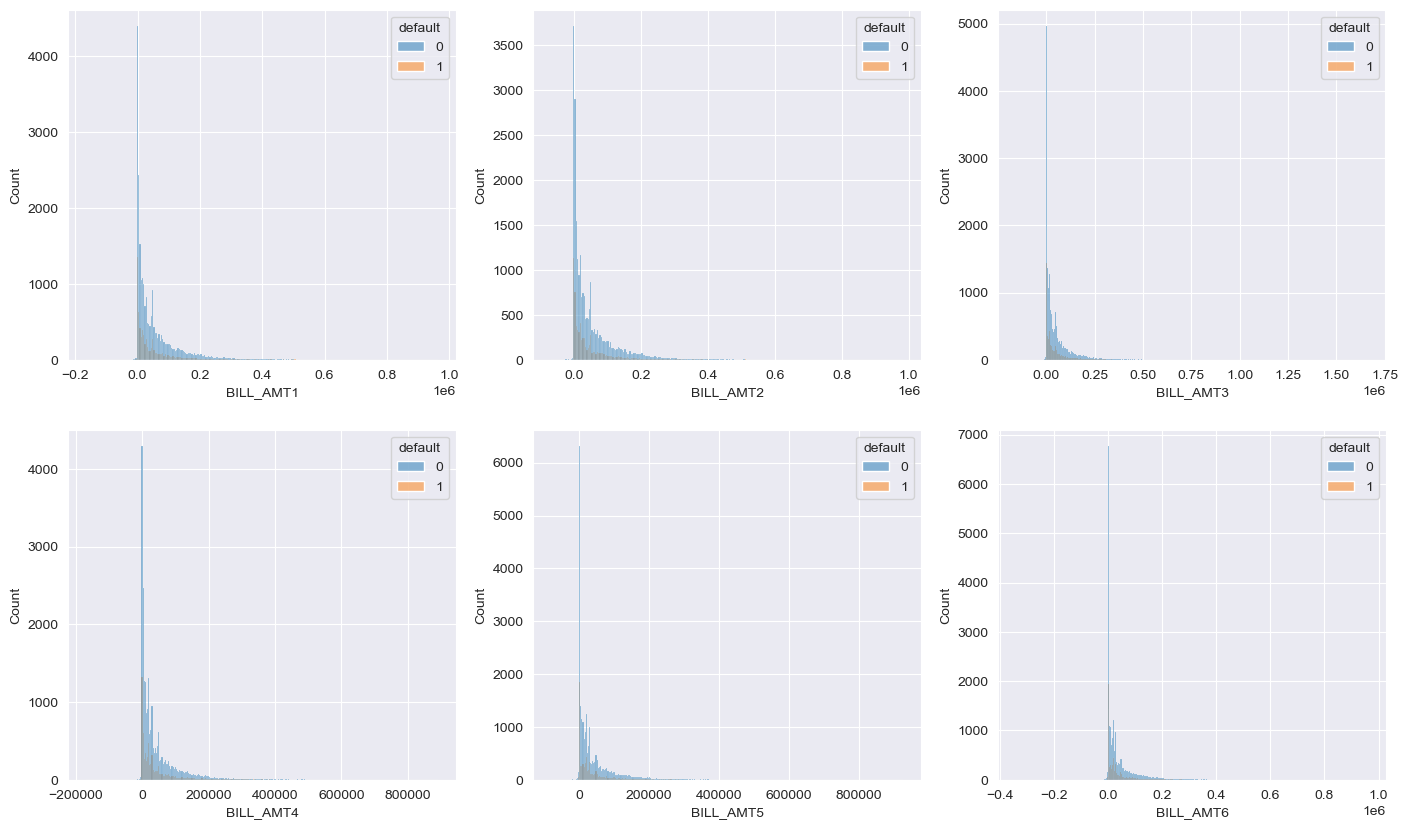

In [28]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "BILL_AMT1", hue = "default", data = data, ax = ax[0, 0])
sns.histplot(x = "BILL_AMT2", hue = "default", data = data, ax = ax[0, 1])
sns.histplot(x = "BILL_AMT3", hue = "default", data = data, ax = ax[0, 2])
sns.histplot(x = "BILL_AMT4", hue = "default", data = data, ax = ax[1, 0])
sns.histplot(x = "BILL_AMT5", hue = "default", data = data, ax = ax[1, 1])
sns.histplot(x = "BILL_AMT6", hue = "default", data = data, ax = ax[1, 2])
plt.show()

## Comparing Amount of Previous Payments for 6 months, from April - September 2005, between defaulters and non-defaulters

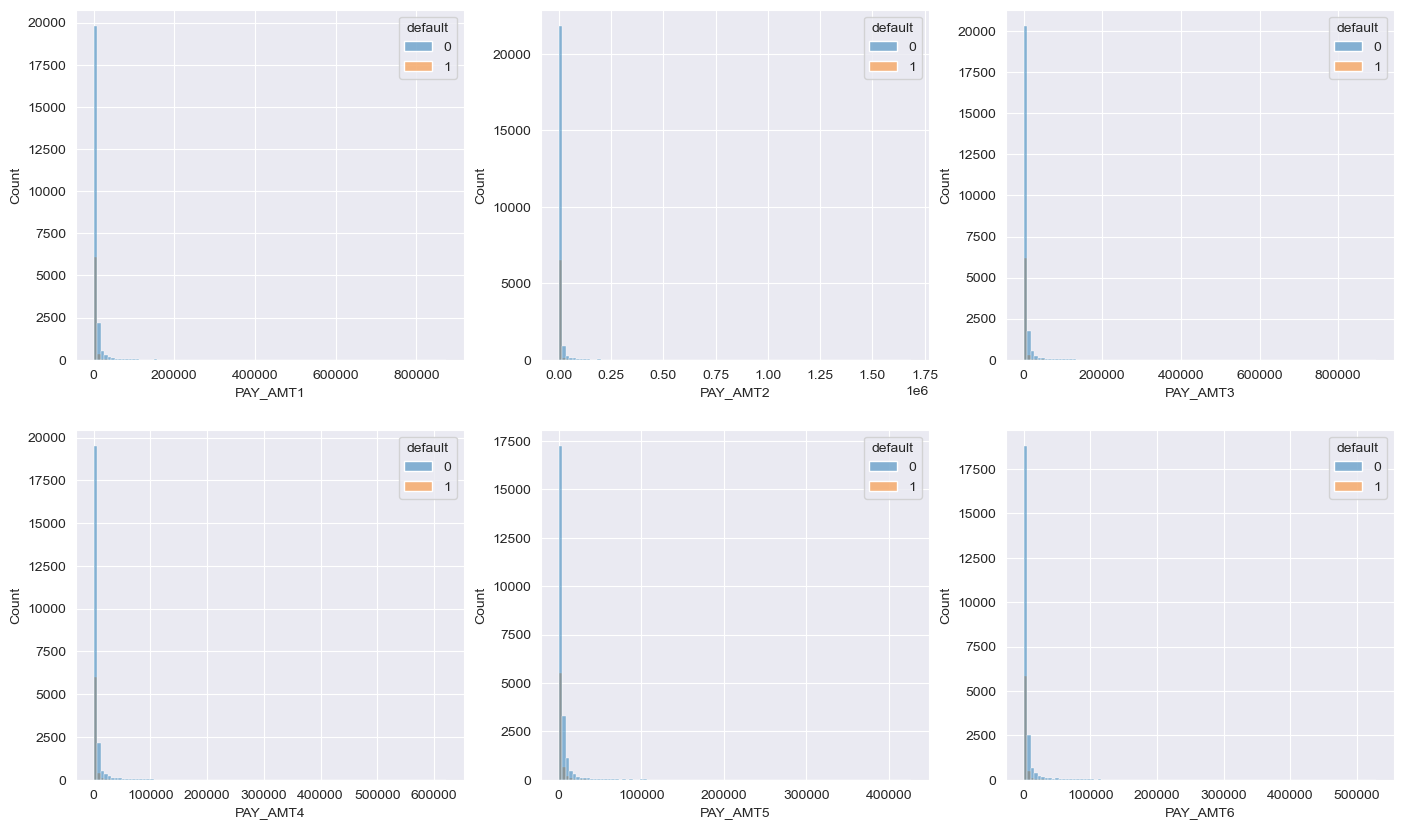

In [29]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "PAY_AMT1", hue = "default", data = data, ax = ax[0, 0], bins=100)
sns.histplot(x = "PAY_AMT2", hue = "default", data = data, ax = ax[0, 1], bins=100)
sns.histplot(x = "PAY_AMT3", hue = "default", data = data, ax = ax[0, 2], bins=100)
sns.histplot(x = "PAY_AMT4", hue = "default", data = data, ax = ax[1, 0], bins=100)
sns.histplot(x = "PAY_AMT5", hue = "default", data = data, ax = ax[1, 1], bins=100)
sns.histplot(x = "PAY_AMT6", hue = "default", data = data, ax = ax[1, 2], bins=100)
plt.show()

# Data Pre-Processing

## One Hot Encoding

In [30]:
# Get dummy variables for Education and Marriage (since they have more than 2 categories)
data = pd.get_dummies(data, columns = ["EDUCATION", "MARRIAGE"])
data.head()

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT5,PAY_AMT6,default,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,1,24,1,1,0,0,0,0,3913,...,0,0,1,0,1,0,0,1,0,0
2,120000,1,26,0,1,0,0,0,1,2682,...,0,2000,1,0,1,0,0,0,1,0
3,90000,1,34,0,0,0,0,0,0,29239,...,1000,5000,0,0,1,0,0,0,1,0
4,50000,1,37,0,0,0,0,0,0,46990,...,1069,1000,0,0,1,0,0,1,0,0
5,50000,0,57,0,0,0,0,0,0,8617,...,689,679,0,0,1,0,0,1,0,0


## Feature scaling

In [31]:
# Scale dataset to be between [0, 1] as range of each variable varies a lot. Min-max scaler being used.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
col_names = data.columns.tolist()
data = pd.DataFrame(scaled_data, columns = col_names)
data.head()

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT5,PAY_AMT6,default,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0.010101,1.0,0.051724,1.0,1.0,0.0,0.0,0.0,0.0,0.149982,...,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.111111,1.0,0.086207,0.0,1.0,0.0,0.0,0.0,1.0,0.148892,...,0.000000,0.003783,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.080808,1.0,0.224138,0.0,0.0,0.0,0.0,0.0,0.0,0.172392,...,0.002345,0.009458,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.040404,1.0,0.275862,0.0,0.0,0.0,0.0,0.0,0.0,0.188100,...,0.002506,0.001892,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.040404,0.0,0.620690,0.0,0.0,0.0,0.0,0.0,0.0,0.154144,...,0.001615,0.001284,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [32]:
y_data = data["default"]
X_data = data.drop(["default"], axis = 1)

# Initial Model Building
We will run our desired models on all features first before doing features selection to justify that feature selection is indeed helpful in our predictive modelling

The models we are interested in building are
1. Logistic Regression
2. Support Vector Machine
3. Random Forest
4. XGBoost
5. Neural Network

## Creating Training and Testing data set
we will use a train/test size of 80/20

In [34]:
# creating training and testing data to be used for model selection
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.20, random_state = 0)

## Logistic Regression

### Model Fitting for Logistic Regression

In [171]:
logistic_regression_model = LogisticRegression(max_iter = 1000, random_state = 0)
logistic_regression_model.fit(X_train, y_train)

logistic_regression_model_y_pred = logistic_regression_model.predict(X_test)

### Evaluation Metrics for Logistic Regression

In [172]:
print(classification_report(y_test, logistic_regression_model_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.82995   0.95577   0.88843      4703
         1.0    0.64384   0.28990   0.39979      1297

    accuracy                        0.81183      6000
   macro avg    0.73689   0.62284   0.64411      6000
weighted avg    0.78972   0.81183   0.78280      6000



In [173]:
print("AUC: " + str(roc_auc_score(y_test, logistic_regression_model_y_pred)))

AUC: 0.6228363398024621


In [174]:
pd.DataFrame(confusion_matrix(y_test, logistic_regression_model_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,4495,208
True 1,921,376


## Support Vector Machine

### Model Fitting for SVM

In [175]:
svm_model = SVC(random_state = 0)
svm_model.fit(X_train, y_train)
svm_model_y_pred = svm_model.predict(X_test)

#### Evaluation Metrics for SVM

In [176]:
print(classification_report(y_test, svm_model_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.83049   0.95322   0.88763      4703
         1.0    0.63455   0.29453   0.40232      1297

    accuracy                        0.81083      6000
   macro avg    0.73252   0.62387   0.64498      6000
weighted avg    0.78814   0.81083   0.78273      6000



In [177]:
print("AUC: " + str(roc_auc_score(y_test, svm_model_y_pred)))

AUC: 0.6238735884557356


In [178]:
pd.DataFrame(confusion_matrix(y_test, svm_model_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,4483,220
True 1,915,382


## Random Forest

### Model fitting for Random Forest

In [179]:
random_forest_model = RandomForestClassifier(random_state = 0) 
random_forest_model.fit(X_train, y_train)

random_forest_model_y_pred = random_forest_model.predict(X_test)

#### Evaluation Metrics for Random Forest

In [180]:
print(classification_report(y_test, random_forest_model_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.84300   0.93961   0.88869      4703
         1.0    0.62533   0.36546   0.46131      1297

    accuracy                        0.81550      6000
   macro avg    0.73416   0.65254   0.67500      6000
weighted avg    0.79595   0.81550   0.79630      6000



In [181]:
print("AUC: " + str(roc_auc_score(y_test, random_forest_model_y_pred)))

AUC: 0.6525358819671035


In [182]:
pd.DataFrame(confusion_matrix(y_test, random_forest_model_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,4419,284
True 1,823,474


## XGBoost

### Model fitting for XGBoost

In [183]:
xgboost_model = XGBClassifier(random_state = 0)
xgboost_model.fit(X_train, y_train)

xgboost_model_y_pred = xgboost_model.predict(X_test)

### Evaluation metrics for XGBoost

In [184]:
print(classification_report(y_test, xgboost_model_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.84132   0.93685   0.88652      4703
         1.0    0.61075   0.35929   0.45243      1297

    accuracy                        0.81200      6000
   macro avg    0.72603   0.64807   0.66947      6000
weighted avg    0.79148   0.81200   0.79268      6000



In [185]:
print("AUC: " + str(roc_auc_score(y_test, xgboost_model_y_pred)))

AUC: 0.6480697453404551


In [186]:
pd.DataFrame(confusion_matrix(y_test, xgboost_model_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,4406,297
True 1,831,466


## Neural Network

### Building Neural Network

We will be building a dense neural network with 2 hidden layers

In [187]:
tf.random.set_seed(0)

In [188]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation = "relu"), #Hidden 1
    tf.keras.layers.Dense(8, activation = "relu"), #Hidden 2
    tf.keras.layers.Dense(1, activation = "sigmoid") #Output
])

In [189]:
# Hyperparameters
learning_rate = 0.01
loss_function = tf.keras.losses.binary_crossentropy
optimiser_function = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [190]:
nn_model.compile(
    loss = loss_function,
    optimizer = optimiser_function,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

In [191]:
nn_model.fit(X_train, y_train, epochs=50)

Epoch 1/50


2023-04-08 14:58:59.596691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 7s 9ms/step - loss: 0.4537 - accuracy: 0.8041 - recall: 0.3094 - precision: 0.6197
Epoch 2/50
750/750 [==============================] - 7s 9ms/step - loss: 0.4496 - accuracy: 0.8066 - recall: 0.3120 - precision: 0.6325
Epoch 3/50
750/750 [==============================] - 7s 9ms/step - loss: 0.4483 - accuracy: 0.8070 - recall: 0.3182 - precision: 0.6311
Epoch 4/50
750/750 [==============================] - 7s 9ms/step - loss: 0.4479 - accuracy: 0.8078 - recall: 0.3263 - precision: 0.6318
Epoch 5/50
750/750 [==============================] - 6s 9ms/step - loss: 0.4462 - accuracy: 0.8090 - recall: 0.3216 - precision: 0.6407
Epoch 6/50
750/750 [==============================] - 7s 9ms/step - loss: 0.4455 - accuracy: 0.8087 - recall: 0.3255 - precision: 0.6369
Epoch 7/50
750/750 [==============================] - 7s 9ms/step - loss: 0.4451 - accuracy: 0.8083 - recall: 0.3340 - precision: 0.6307
Epoch 8/50
750/750 [==============================] 

In [192]:
# Make predictions
nn_pred_raw = nn_model.predict(X_test)

nn_pred = [1 if p > 0.5 else 0 for p in np.ravel(nn_pred_raw)]

 90/188 [=============>................] - ETA: 0s

2023-04-08 15:04:32.810346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 0s 2ms/step


### Evaluation metrics for Neural Network

In [193]:
print(classification_report(y_test, nn_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.84267   0.93727   0.88746      4703
         1.0    0.61638   0.36546   0.45886      1297

    accuracy                        0.81367      6000
   macro avg    0.72953   0.65137   0.67316      6000
weighted avg    0.79375   0.81367   0.79481      6000



In [194]:
print("AUC: " + str(roc_auc_score(y_test, nn_pred)))

AUC: 0.6513664156689959


In [195]:
pd.DataFrame(confusion_matrix(y_test, nn_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,4408,295
True 1,823,474


# Feature selection

### Filter Method - Chi2

H0: There is no relationship between "default" and other categorical independent variables.

H1: There is a relationship between "default" and other categorical independent variables.

Testing this hypothesis at 5% level of significance, with (r-1)(c-1) degrees of freedom

In [35]:
# extracting categorical columns
x = X_train[["SEX", "PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "EDUCATION_1", "EDUCATION_2", "EDUCATION_3", "EDUCATION_4", "MARRIAGE_1", "MARRIAGE_2", "MARRIAGE_3"]]
y = y_train

# chi2
statistics = chi2(x, y)

# # creating the chi2 statistics
# chi_sq= SelectKBest(chi2, k = 8)
# chi_sq.fit(x, y)

# observing the chi2 scores
chi_scores = pd.DataFrame(list(zip(x.columns, *statistics)), columns =["feature", "score", "pvalue"])
chi_scores

,feature,score,pvalue
0,SEX,19.328592,1.100461e-05
1,PAY_1,2504.407508,0.000000e+00
2,PAY_2,2336.386495,0.000000e+00
3,PAY_3,1783.040210,0.000000e+00
4,PAY_4,1596.935908,0.000000e+00
5,PAY_5,1567.964929,0.000000e+00
6,PAY_6,1352.401621,4.632186e-296
7,EDUCATION_1,39.102150,4.022009e-10
8,EDUCATION_2,20.157046,7.133698e-06
9,EDUCATION_3,14.052988,1.777313e-04


In [36]:
# selecting the features that reject the null hypothesis (5%)
significant_features = chi_scores[chi_scores["pvalue"] < 0.05]["feature"]
significant_features.tolist()

['SEX',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'EDUCATION_1',
 'EDUCATION_2',
 'EDUCATION_3',
 'EDUCATION_4',
 'MARRIAGE_1',
 'MARRIAGE_2']

Features that have p-value less than 0.05 are

'SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'MARRIAGE_1', 'MARRIAGE_2'

### Wrapper Method - Forward Selection
We use Linear Regression as our test for variables to keep

In [60]:
# Forward Selection
lreg = LinearRegression()
fws = sfs(lreg, k_features=10, forward=True, scoring='r2', cv = 5) # keep approximately half of the total number of features
fws.fit(X_train, y_train)
table = pd.DataFrame(fws.subsets_).T
table

,feature_idx,cv_scores,avg_score,feature_names
1,"(3,)","[0.1493453338652141, 0.15603158985458587, 0.10...",0.134645,"(PAY_1,)"
2,"(3, 7)","[0.16689715979474085, 0.18346492163381334, 0.1...",0.157067,"(PAY_1, PAY_5)"
3,"(3, 5, 7)","[0.1776180954004405, 0.1919190131535382, 0.143...",0.166702,"(PAY_1, PAY_3, PAY_5)"
4,"(0, 3, 5, 7)","[0.1816902129537168, 0.195047685075718, 0.1462...",0.170809,"(LIMIT_BAL, PAY_1, PAY_3, PAY_5)"
5,"(0, 3, 5, 7, 8)","[0.18244146637156478, 0.19761495156268338, 0.1...",0.172928,"(LIMIT_BAL, PAY_1, PAY_3, PAY_5, PAY_6)"
6,"(0, 3, 5, 7, 8, 26)","[0.18471736060559452, 0.19664098349476122, 0.1...",0.174311,"(LIMIT_BAL, PAY_1, PAY_3, PAY_5, PAY_6, MARRIA..."
7,"(0, 3, 4, 5, 7, 8, 26)","[0.18419494977466977, 0.19493017522635647, 0.1...",0.175213,"(LIMIT_BAL, PAY_1, PAY_2, PAY_3, PAY_5, PAY_6,..."
8,"(0, 3, 4, 5, 7, 8, 24, 26)","[0.18395368107918797, 0.19614342955272046, 0.1...",0.175969,"(LIMIT_BAL, PAY_1, PAY_2, PAY_3, PAY_5, PAY_6,..."
9,"(0, 1, 3, 4, 5, 7, 8, 24, 26)","[0.18523891652939084, 0.19726953839960093, 0.1...",0.176697,"(LIMIT_BAL, SEX, PAY_1, PAY_2, PAY_3, PAY_5, P..."
10,"(0, 1, 3, 4, 5, 7, 8, 15, 24, 26)","[0.18600923529533686, 0.19801381812057617, 0.1...",0.177418,"(LIMIT_BAL, SEX, PAY_1, PAY_2, PAY_3, PAY_5, P..."


The top 10 features to select will be LIMIT_BAL, SEX, PAY_1, PAY_2, PAY_3, PAY_5, PAY_6, PAY_AMT1, EDUCATION_4, MARRIAGE_2

### Embedded Method - Random Forest

In [61]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.06164632, 0.01267104, 0.06781958, 0.06520381, 0.03397051,
       0.0212019 , 0.01812225, 0.01525486, 0.01892131, 0.0678045 ,
       0.05917926, 0.05643935, 0.05404311, 0.05282601, 0.05430341,
       0.05421721, 0.04942933, 0.0488772 , 0.0463043 , 0.04461673,
       0.04904686, 0.0089207 , 0.01012574, 0.00821934, 0.00127353,
       0.00875422, 0.00887152, 0.00193611])

<BarContainer object of 28 artists>

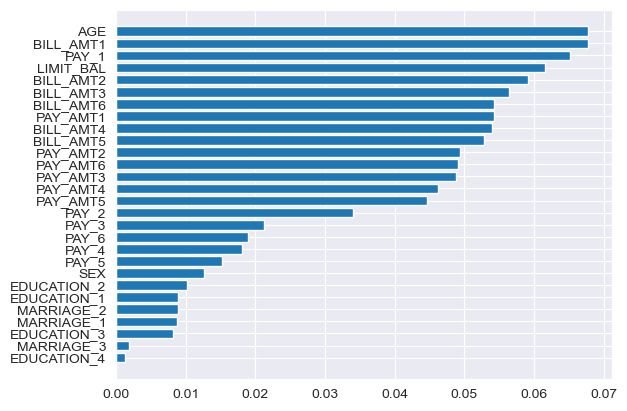

In [62]:
# Plot RF scores
sorted_idx = rf.feature_importances_.argsort()
plt.barh(rf.feature_names_in_[sorted_idx], rf.feature_importances_[sorted_idx])

The most important feature is "AGE" and the least important feature is "EDUCATION_4"

From the 3 feature selection methods as shown above, we derive these conclusions
1. From chi2 test, ‘SEX’, ‘PAY_1’, ‘PAY_2’, ‘PAY_3’, ‘PAY_4’, ‘PAY_5’, ‘PAY_6’, ‘EDUCATION_1’, ‘EDUCATION_2’, ‘EDUCATION_3’, ‘EDUCATION_4’, ‘MARRIAGE_1’, ‘MARRIAGE_2’ are features whose p-value are less than 0.05
2. From forward selection, 'LIMIT_BAL', 'SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'EDUCATION_4', 'MARRIAGE_2' are the 10 most important features
3. From Embedded method, 'AGE', 'BILL_AMT1', 'PAY_1', 'LIMIT_BAL', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT6', 'BILL_AMT4', 'PAY_AMT1', 'BILL_AMT5' are the 10 most important features

For categorical variables, we will select features that appear in both (1) and (2)
These features are 'SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_5', 'PAY_6', 'MARRIAGE_2', 'EDUCATION_4'

For continuous variables, we will select features that appear in both (2) and (3)
These features are 'LIMIT_BAL', 'PAY_AMT1'

As such, our final set of selected features are 'SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_5', 'PAY_6', 'MARRIAGE_2', 'EDUCATION_4', 'LIMIT_BAL', 'PAY_AMT1'

In [34]:
features_selected = [
    'SEX',
    'PAY_1',
    'PAY_2',
    'PAY_3',
    'PAY_5',
    'PAY_6',
    'MARRIAGE_2',
    'EDUCATION_4',
    'LIMIT_BAL',
    'PAY_AMT1'
]

## Refactoring dataset

In [35]:
X_train = X_train[features_selected]
X_train.head()

,SEX,PAY_1,PAY_2,PAY_3,PAY_5,PAY_6,MARRIAGE_2,EDUCATION_4,LIMIT_BAL,PAY_AMT1
3225,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.010101,0.003434
11815,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.252525,0.000189
7338,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.001717
14980,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.020202,0.002061
27167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003205


In [36]:
X_test = X_test[features_selected]
X_test.head()

,SEX,PAY_1,PAY_2,PAY_3,PAY_5,PAY_6,MARRIAGE_2,EDUCATION_4,LIMIT_BAL,PAY_AMT1
8225,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.010101,0.000000
10794,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.010101,0.003892
9163,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.001086
26591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.005724
6631,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.141414,0.008001


# Creating a balanced dataset using SMOTE

In [37]:
sm = SMOTE(random_state=0, sampling_strategy= 1.0)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)

In [38]:
y_SMOTE.value_counts()

0.0    18661
1.0    18661
Name: default, dtype: int64

# Model Selection

We will now run the 5 models on the dataset that has undergone feature selection, followed by using the balanced dataset from SMOTE and finally tune the hyparameters of each model.
1. Logistic Regression
2. Support Vector Machine
3. Random Forest
4. XGBoost
5. Neural Network

## Logistic Regression

### Model Fitting for Logistic Regression after Feature Selection

In [202]:
logistic_regression_model = LogisticRegression(max_iter = 1000, random_state = 0)
logistic_regression_model.fit(X_train, y_train)

logistic_regression_model_y_pred = logistic_regression_model.predict(X_test)

In [203]:
print(classification_report(y_test, logistic_regression_model_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.83019   0.95322   0.88746      4703
         1.0    0.63333   0.29298   0.40063      1297

    accuracy                        0.81050      6000
   macro avg    0.73176   0.62310   0.64405      6000
weighted avg    0.78763   0.81050   0.78222      6000



In [204]:
print("AUC: " + str(roc_auc_score(y_test, logistic_regression_model_y_pred)))

AUC: 0.6231025784326053


In [205]:
pd.DataFrame(confusion_matrix(y_test, logistic_regression_model_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,4483,220
True 1,917,380


### Model Fitting for Logistic Regression on Balanced Dataset after SMOTE

In [326]:
smote_lr = LogisticRegression(max_iter = 1000, random_state = 0)
smote_lr.fit(X_SMOTE, y_SMOTE)

smote_lr_y_pred = smote_lr.predict(X_test)

In [327]:
print(classification_report(y_test, smote_lr_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.87679   0.82160   0.84830      4703
         1.0    0.47332   0.58134   0.52180      1297

    accuracy                        0.76967      6000
   macro avg    0.67505   0.70147   0.68505      6000
weighted avg    0.78957   0.76967   0.77772      6000



In [328]:
print("AUC: " + str(roc_auc_score(y_test, smote_lr_y_pred)))

AUC: 0.7014723947099172


In [329]:
pd.DataFrame(confusion_matrix(y_test, smote_lr_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,3864,839
True 1,543,754


### Tuning Logistic Regression

In [330]:
# create the grid
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty' : ['l2'],
    'solver' : ['newton-cg', 'lbfgs']
}

In [331]:
# perform grid search and then fit
lr_grid = GridSearchCV(LogisticRegression(max_iter = 1000, random_state = 0), lr_param_grid, scoring = 'accuracy')
lr_grid.fit(X_SMOTE, y_SMOTE)
print(lr_grid.best_params_)

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


In [39]:
optimised_lr = LogisticRegression(C = 10, penalty='l2', solver='newton-cg', max_iter = 1000, random_state = 0)
optimised_lr.fit(X_SMOTE, y_SMOTE)

lr_grid_y_predict = optimised_lr.predict(X_test)

In [40]:
print(classification_report(y_test, lr_grid_y_predict, digits=5))

              precision    recall  f1-score   support

         0.0    0.87750   0.81948   0.84750      4703
         1.0    0.47201   0.58520   0.52255      1297

    accuracy                        0.76883      6000
   macro avg    0.67476   0.70234   0.68502      6000
weighted avg    0.78985   0.76883   0.77725      6000



In [41]:
print("AUC: " + str(roc_auc_score(y_test, lr_grid_y_predict)))

AUC: 0.702336768587645


In [42]:
pd.DataFrame(confusion_matrix(y_test, lr_grid_y_predict), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,3854,849
True 1,538,759


## Support Vector Machine

### Model Fitting for SVM after Feature Selection

In [216]:
svm_model = SVC(random_state = 0)
svm_model.fit(X_train, y_train)
svm_model_y_pred = svm_model.predict(X_test)

In [217]:
print(classification_report(y_test, svm_model_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.83027   0.95173   0.88686      4703
         1.0    0.62726   0.29453   0.40084      1297

    accuracy                        0.80967      6000
   macro avg    0.72877   0.62313   0.64385      6000
weighted avg    0.78639   0.80967   0.78180      6000



In [218]:
print("AUC: " + str(roc_auc_score(y_test, svm_model_y_pred)))

AUC: 0.6231293826296671


In [219]:
pd.DataFrame(confusion_matrix(y_test, svm_model_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,4476,227
True 1,915,382


### Model Fitting for SVM on Balanced Dataset after SMOTE

In [220]:
smote_svm = SVC(random_state = 0)
smote_svm.fit(X_SMOTE, y_SMOTE)
smote_svm_y_pred = smote_svm.predict(X_test)

In [221]:
print(classification_report(y_test, smote_svm_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.88213   0.79247   0.83490      4703
         1.0    0.45014   0.61604   0.52018      1297

    accuracy                        0.75433      6000
   macro avg    0.66614   0.70425   0.67754      6000
weighted avg    0.78875   0.75433   0.76687      6000



In [222]:
print("AUC: " + str(roc_auc_score(y_test, smote_svm_y_pred)))

AUC: 0.7042549490630089


In [223]:
pd.DataFrame(confusion_matrix(y_test, smote_svm_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,3727,976
True 1,498,799


### Tuning SVM

In [90]:
# create the grid
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf']
}

In [91]:
# perform grid search and then fit
svm_grid = GridSearchCV(SVC(random_state = 0), svm_param_grid, scoring = 'accuracy')
svm_grid.fit(X_SMOTE, y_SMOTE)
print(svm_grid.best_params_)

{'C': 100, 'kernel': 'rbf'}


In [43]:
optimised_svm = SVC(random_state = 0, kernel = 'rbf', C = 100, probability=True)
optimised_svm.fit(X_SMOTE, y_SMOTE)

svm_grid_y_pred = optimised_svm.predict(X_test)

In [44]:
print(classification_report(y_test, svm_grid_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.88024   0.79545   0.83570      4703
         1.0    0.45029   0.60756   0.51723      1297

    accuracy                        0.75483      6000
   macro avg    0.66526   0.70150   0.67646      6000
weighted avg    0.78729   0.75483   0.76686      6000



In [45]:
print("AUC: " + str(roc_auc_score(y_test, svm_grid_y_pred)))

AUC: 0.7015028055879291


In [46]:
pd.DataFrame(confusion_matrix(y_test, svm_grid_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,3741,962
True 1,509,788


## Random Forest

### Model Fitting for Random Forest after Feature Selection

In [228]:
random_forest_model = RandomForestClassifier(random_state = 0)
random_forest_model.fit(X_train, y_train)

random_forest_model_y_pred = random_forest_model.predict(X_test)

In [229]:
print(classification_report(y_test, random_forest_model_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.82991   0.88497   0.85655      4703
         1.0    0.45076   0.34233   0.38913      1297

    accuracy                        0.76767      6000
   macro avg    0.64034   0.61365   0.62284      6000
weighted avg    0.74795   0.76767   0.75551      6000



In [230]:
print("AUC: " + str(roc_auc_score(y_test, random_forest_model_y_pred)))

AUC: 0.6136477462916352


In [231]:
pd.DataFrame(confusion_matrix(y_test, random_forest_model_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,4162,541
True 1,853,444


### Model Fitting for Random Forest on Balanced Dataset after SMOTE

In [232]:
smote_rf = RandomForestClassifier(random_state = 0)
smote_rf.fit(X_SMOTE, y_SMOTE)

smote_rf_y_pred = smote_rf.predict(X_test)

In [233]:
print(classification_report(y_test, smote_rf_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.84835   0.73272   0.78631      4703
         1.0    0.35139   0.52506   0.42102      1297

    accuracy                        0.68783      6000
   macro avg    0.59987   0.62889   0.60366      6000
weighted avg    0.74092   0.68783   0.70735      6000



In [234]:
print("AUC: " + str(roc_auc_score(y_test, smote_rf_y_pred)))

AUC: 0.6288908095375727


In [235]:
pd.DataFrame(confusion_matrix(y_test, smote_rf_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,3446,1257
True 1,616,681


### Tuning Random Forest

In [236]:
# create the grid
rf_params_grid = {
    'n_estimators': [10, 50, 100, 250, 500],
    'max_depth': [2, 3, 4, 5]
}

In [237]:
# perform grid search and then fit
rf_grid = GridSearchCV(RandomForestClassifier(random_state = 0), rf_params_grid, scoring = 'accuracy')
rf_grid.fit(X_SMOTE, y_SMOTE)
print(rf_grid.best_params_)

{'max_depth': 5, 'n_estimators': 500}


In [47]:
optimised_rf = RandomForestClassifier(random_state = 0, max_depth = 5, n_estimators = 500)
optimised_rf.fit(X_SMOTE, y_SMOTE)

rf_grid_y_pred = optimised_rf.predict(X_test)

In [48]:
print(classification_report(y_test, rf_grid_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.87853   0.81352   0.84478      4703
         1.0    0.46687   0.59214   0.52209      1297

    accuracy                        0.76567      6000
   macro avg    0.67270   0.70283   0.68344      6000
weighted avg    0.78954   0.76567   0.77502      6000



In [49]:
print("AUC: " + str(roc_auc_score(y_test, rf_grid_y_pred)))

AUC: 0.7028294903874575


In [50]:
pd.DataFrame(confusion_matrix(y_test, rf_grid_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,3826,877
True 1,529,768


## XGBoost

### Model Fitting for XGBoost after Feature Selection

In [242]:
xgboost_model = XGBClassifier(random_state = 0)
xgboost_model.fit(X_train, y_train)

xgboost_model_y_pred = xgboost_model.predict(X_test)

In [243]:
print(classification_report(y_test, xgboost_model_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.83434   0.94238   0.88507      4703
         1.0    0.60610   0.32151   0.42015      1297

    accuracy                        0.80817      6000
   macro avg    0.72022   0.63194   0.65261      6000
weighted avg    0.78500   0.80817   0.78457      6000



In [244]:
print("AUC: " + str(roc_auc_score(y_test, xgboost_model_y_pred)))

AUC: 0.6319441928420171


In [245]:
pd.DataFrame(confusion_matrix(y_test, xgboost_model_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,4432,271
True 1,880,417


### Model Fitting for XGBoost on Balanced Dataset after SMOTE

In [246]:
smote_xgboost = XGBClassifier(random_state = 0)
smote_xgboost.fit(X_SMOTE, y_SMOTE)

smote_xgboost_y_pred = smote_xgboost.predict(X_test)

In [247]:
print(classification_report(y_test, smote_xgboost_y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.86759   0.79970   0.83226      4703
         1.0    0.43423   0.55744   0.48818      1297

    accuracy                        0.74733      6000
   macro avg    0.65091   0.67857   0.66022      6000
weighted avg    0.77391   0.74733   0.75789      6000



In [248]:
print("AUC: " + str(roc_auc_score(y_test, smote_xgboost_y_pred)))

AUC: 0.6785712821963898


In [249]:
pd.DataFrame(confusion_matrix(y_test, smote_xgboost_y_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,3761,942
True 1,574,723


### Tuning XGBoost

In [250]:
# create the grid
xgboost_params_grid = {
    'n_estimators': [10, 50, 100, 250, 500],
    'max_depth': [2, 3, 4, 5]
}

In [251]:
# perform grid search and then fit
xgboost_grid = GridSearchCV(XGBClassifier(random_state = 0), xgboost_params_grid, scoring = 'accuracy')
xgboost_grid.fit(X_SMOTE, y_SMOTE)
print(xgboost_grid.best_params_)

{'max_depth': 5, 'n_estimators': 500}


In [64]:
optimised_xgboost = XGBClassifier(random_state = 0, max_depth = 5, n_estimators = 500)
optimised_xgboost.fit(X_SMOTE, y_SMOTE)

xgboost_grid_y_predict = optimised_xgboost.predict(X_test)

In [65]:
print(classification_report(y_test, xgboost_grid_y_predict, digits=5))

              precision    recall  f1-score   support

         0.0    0.86080   0.79417   0.82614      4703
         1.0    0.41722   0.53431   0.46856      1297

    accuracy                        0.73800      6000
   macro avg    0.63901   0.66424   0.64735      6000
weighted avg    0.76491   0.73800   0.74885      6000



In [66]:
print("AUC: " + str(roc_auc_score(y_test, xgboost_grid_y_predict)))

AUC: 0.6642419387811812


In [67]:
pd.DataFrame(confusion_matrix(y_test, xgboost_grid_y_predict), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,3735,968
True 1,604,693


## Neural Network

### Helper Functions

In [58]:
# this function will help us to visualise the training graphs for the neural network
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)

### Model Fitting for Neural Network after Feature Selection

In [125]:
tf.random.set_seed(0)

In [126]:
nn_fs_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation = "relu"), #Hidden 1
    tf.keras.layers.Dense(8, activation = "sigmoid"), #Hidden 2
    tf.keras.layers.Dense(1, activation = "sigmoid") #Output
])

#Hyperparameters
learning_rate = 0.01
loss_function = tf.keras.losses.binary_crossentropy
optimiser_function = tf.keras.optimizers.Adam(learning_rate=learning_rate)

nn_fs_model.compile(
    loss = loss_function,
    optimizer = optimiser_function,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

In [127]:
history_nn_fs = nn_fs_model.fit(X_train, y_train, epochs=50)

Epoch 1/50
  1/750 [..............................] - ETA: 5:27 - loss: 0.6599 - accuracy: 0.6875 - recall: 0.0000e+00 - precision: 0.0000e+00

2023-04-08 05:32:15.731019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 6s 8ms/step - loss: 0.4547 - accuracy: 0.8028 - recall: 0.3023 - precision: 0.6158
Epoch 2/50
750/750 [==============================] - 6s 8ms/step - loss: 0.4500 - accuracy: 0.8059 - recall: 0.3169 - precision: 0.6257
Epoch 3/50
750/750 [==============================] - 6s 8ms/step - loss: 0.4491 - accuracy: 0.8059 - recall: 0.3235 - precision: 0.6228
Epoch 4/50
750/750 [==============================] - 919s 1s/step - loss: 0.4500 - accuracy: 0.8074 - recall: 0.3199 - precision: 0.6328
Epoch 5/50
750/750 [==============================] - 6s 8ms/step - loss: 0.4489 - accuracy: 0.8058 - recall: 0.3171 - precision: 0.6250
Epoch 6/50
750/750 [==============================] - 6s 8ms/step - loss: 0.4484 - accuracy: 0.8068 - recall: 0.3272 - precision: 0.6257
Epoch 7/50
750/750 [==============================] - 6s 8ms/step - loss: 0.4484 - accuracy: 0.8074 - recall: 0.3267 - precision: 0.6294
Epoch 8/50
750/750 [==============================]

(0.0, 1.0)

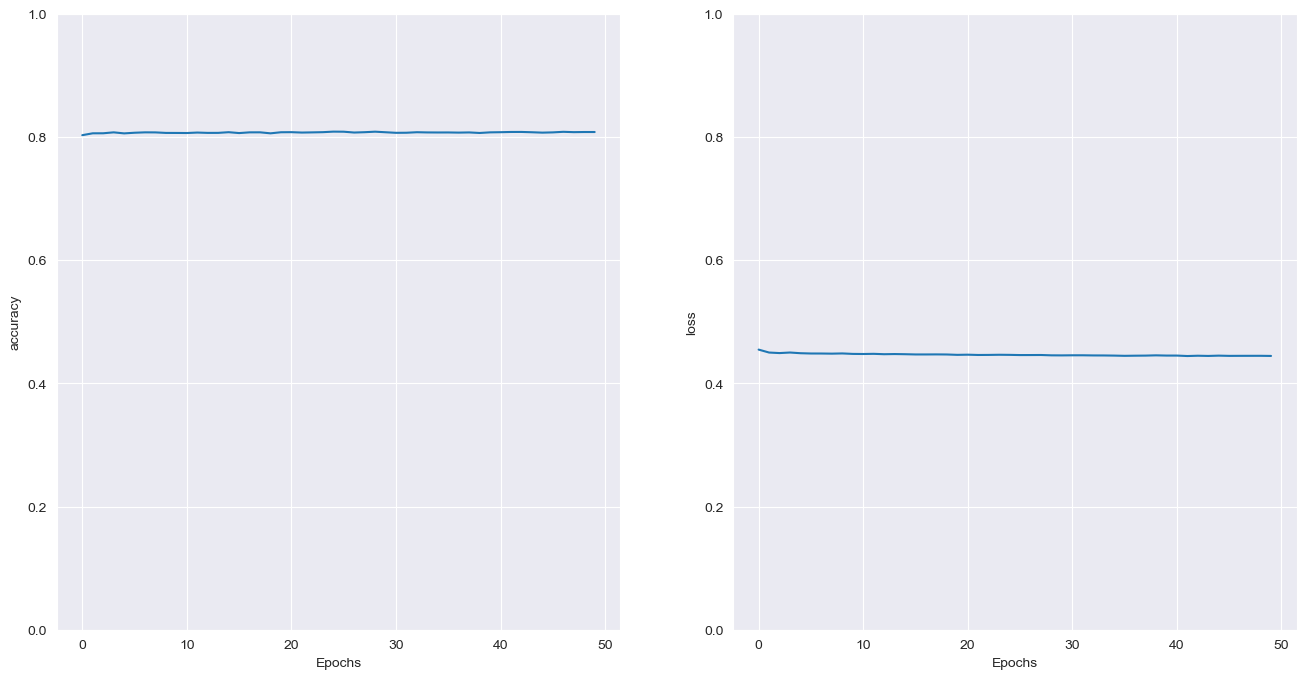

In [128]:
# Visualising the learning curves
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_nn_fs, 'accuracy')
plt.ylim(0, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_nn_fs, 'loss')
plt.ylim(0, 1)

In [166]:
#Make predictions
nn_fs_pred_raw = nn_fs_model.predict(X_test)
nn_fs_pred = [1 if p > 0.5 else 0 for p in np.ravel(nn_fs_pred_raw)]

print(classification_report(y_test, nn_fs_pred, digits=5))

188/188 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0    0.83399   0.94642   0.88665      4703
         1.0    0.61991   0.31689   0.41939      1297

    accuracy                        0.81033      6000
   macro avg    0.72695   0.63165   0.65302      6000
weighted avg    0.78771   0.81033   0.78565      6000



In [130]:
print("AUC: " + str(roc_auc_score(y_test, nn_fs_pred)))

AUC: 0.631651150014812


In [131]:
pd.DataFrame(confusion_matrix(y_test, nn_fs_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,4451,252
True 1,886,411


### Model Fitting for Neural Network on Balanced Dataset after SMOTE

In [263]:
nn_smote_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation = "relu"), #Hidden 1
    tf.keras.layers.Dense(8, activation = "sigmoid"), #Hidden 2
    tf.keras.layers.Dense(1, activation = "sigmoid") #Output
])

#Hyperparameters
learning_rate = 0.01
loss_function = tf.keras.losses.binary_crossentropy
optimiser_function = tf.keras.optimizers.Adam(learning_rate=learning_rate)

nn_smote_model.compile(
    loss = loss_function,
    optimizer = optimiser_function,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

In [264]:
history_nn_model_smote = nn_smote_model.fit(X_SMOTE, y_SMOTE, epochs=50, batch_size=50)

Epoch 1/50


2023-04-08 15:18:40.111880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


747/747 [==============================] - 8s 10ms/step - loss: 0.5897 - accuracy: 0.6990 - recall: 0.6026 - precision: 0.7465
Epoch 2/50
747/747 [==============================] - 7s 10ms/step - loss: 0.5828 - accuracy: 0.7045 - recall: 0.6132 - precision: 0.7502
Epoch 3/50
747/747 [==============================] - 7s 10ms/step - loss: 0.5808 - accuracy: 0.7049 - recall: 0.6107 - precision: 0.7524
Epoch 4/50
747/747 [==============================] - 7s 10ms/step - loss: 0.5801 - accuracy: 0.7055 - recall: 0.6181 - precision: 0.7491
Epoch 5/50
747/747 [==============================] - 7s 10ms/step - loss: 0.5795 - accuracy: 0.7050 - recall: 0.6232 - precision: 0.7451
Epoch 6/50
747/747 [==============================] - 7s 10ms/step - loss: 0.5787 - accuracy: 0.7054 - recall: 0.6192 - precision: 0.7482
Epoch 7/50
747/747 [==============================] - 7s 9ms/step - loss: 0.5777 - accuracy: 0.7058 - recall: 0.6275 - precision: 0.7440
Epoch 8/50
747/747 [==========================

(0.0, 1.0)

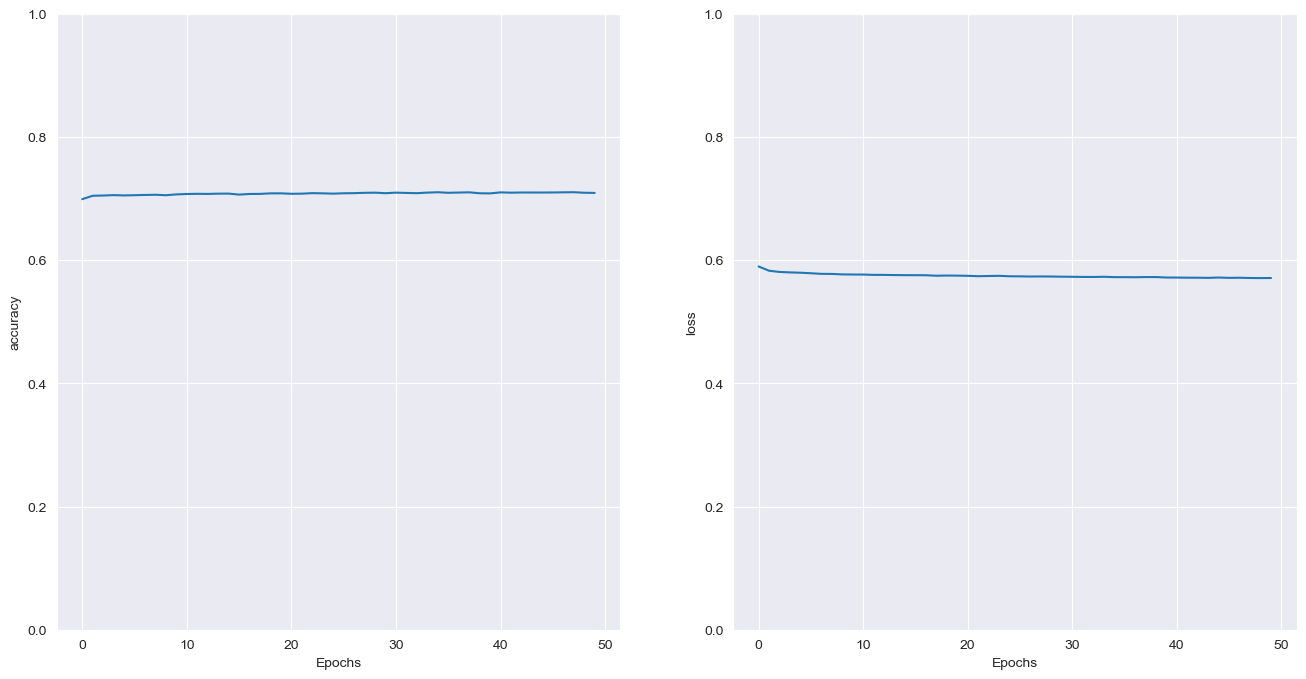

In [265]:
# Visualising the learning curves
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_nn_model_smote, 'accuracy')
plt.ylim(0, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_nn_model_smote, 'loss')
plt.ylim(0, 1)

In [266]:
# making predictions on test set
nn_smote_pred_raw = nn_smote_model.predict(X_test)

nn_smote_pred = [1 if p > 0.5 else 0 for p in np.ravel(nn_smote_pred_raw)]

print(classification_report(y_test, nn_smote_pred, digits=5))

 92/188 [=============>................] - ETA: 0s

2023-04-08 15:24:41.627117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0    0.87929   0.79609   0.83562      4703
         1.0    0.44948   0.60370   0.51530      1297

    accuracy                        0.75450      6000
   macro avg    0.66438   0.69989   0.67546      6000
weighted avg    0.78638   0.75450   0.76638      6000



In [267]:
print("AUC: " + str(roc_auc_score(y_test, nn_smote_pred)))

AUC: 0.6998942258841326


In [268]:
pd.DataFrame(confusion_matrix(y_test, nn_smote_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,3744,959
True 1,514,783


### Neural Network Tuning

In [138]:
def define_model(learning_rate = 0.001, neurons_1 = 8, neurons_2 = 4):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_1, activation = "relu", input_shape=(10, )),
        tf.keras.layers.Dense(neurons_2, activation = "sigmoid"),
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer = optimizer,
        metrics = ['acc']
    )
    return model

learning_rate = [0.001, 0.01, 0.1]
neurons_1 = [8, 16]
neurons_2 = [4, 8]

param_grid = dict(learning_rate = learning_rate, neurons_1 = neurons_1, neurons_2 = neurons_2)

In [139]:
nn_model_temp = KerasClassifier(model = define_model, epochs=50, batch_size = 50,
                                learning_rate=0.001, neurons_1=8, neurons_2=4, verbose=0)
nn_grid_model = GridSearchCV(estimator = nn_model_temp, param_grid = param_grid, scoring = "accuracy", cv = 3, verbose = 0)

In [140]:
nn_grid_model.fit(X_SMOTE, y_SMOTE)
print(nn_grid_model.best_params_)

2023-04-08 06:33:53.693735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-08 06:35:51.294481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-08 06:35:51.864794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-08 06:37:49.100805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-08 06:37:49.662360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-08 07:00:59.427460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-08 07:01:00.004853: I tensorflow/core/grappler/optimizers/cust

{'learning_rate': 0.01, 'neurons_1': 8, 'neurons_2': 8}


### Creating the Optimised Neural Network from the Tuned Hyperparameters

In [55]:
optimised_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation = "relu", input_shape=(10, )),
    tf.keras.layers.Dense(8, activation = "sigmoid"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

optimised_nn.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer = optimizer,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

Metal device set to: Apple M1 Pro


2023-04-09 13:30:23.189610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-09 13:30:23.189904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [56]:
optimised_nn_history = optimised_nn.fit(X_SMOTE, y_SMOTE, batch_size=50, epochs=50)

Epoch 1/50


2023-04-09 13:30:23.526673: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-09 13:30:23.865839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


747/747 [==============================] - 7s 9ms/step - loss: 0.5882 - accuracy: 0.7016 - recall: 0.6052 - precision: 0.7497
Epoch 2/50
747/747 [==============================] - 6s 9ms/step - loss: 0.5839 - accuracy: 0.7038 - recall: 0.6047 - precision: 0.7542
Epoch 3/50
747/747 [==============================] - 7s 9ms/step - loss: 0.5826 - accuracy: 0.7040 - recall: 0.6089 - precision: 0.7520
Epoch 4/50
747/747 [==============================] - 6s 9ms/step - loss: 0.5814 - accuracy: 0.7045 - recall: 0.6133 - precision: 0.7501
Epoch 5/50
747/747 [==============================] - 6s 8ms/step - loss: 0.5806 - accuracy: 0.7056 - recall: 0.6162 - precision: 0.7504
Epoch 6/50
747/747 [==============================] - 6s 8ms/step - loss: 0.5802 - accuracy: 0.7054 - recall: 0.6165 - precision: 0.7499
Epoch 7/50
747/747 [==============================] - 6s 9ms/step - loss: 0.5793 - accuracy: 0.7062 - recall: 0.6178 - precision: 0.7505
Epoch 8/50
747/747 [==============================] 

(0.0, 1.0)

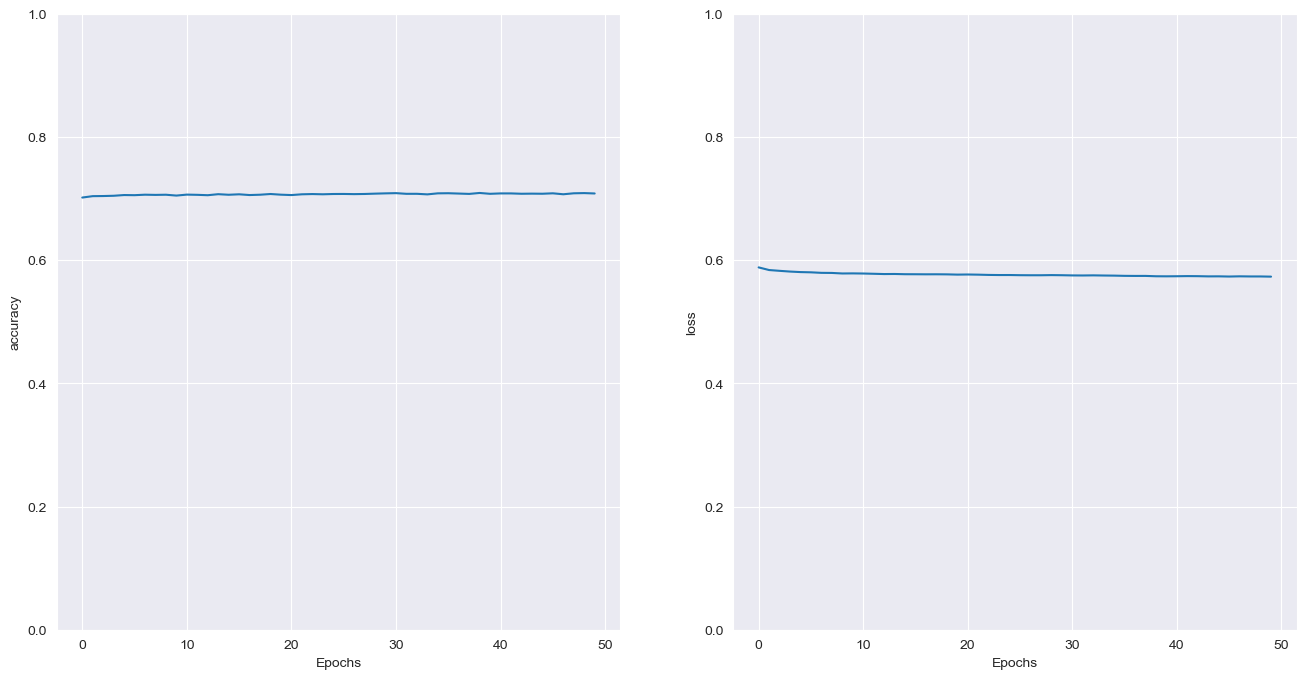

In [59]:
# Visualising the learning curves
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(optimised_nn_history, 'accuracy')
plt.ylim(0, 1)
plt.subplot(1, 2, 2)
plot_graphs(optimised_nn_history, 'loss')
plt.ylim(0, 1)

In [68]:
# Make predictions
nn_grid_pred_raw = optimised_nn.predict(X_test)

nn_grid_pred = [1 if p > 0.5 else 0 for p in np.ravel(nn_grid_pred_raw)]

188/188 [==============================] - 0s 2ms/step


In [69]:
print(classification_report(y_test, nn_grid_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.87457   0.81246   0.84237      4703
         1.0    0.45923   0.57749   0.51161      1297

    accuracy                        0.76167      6000
   macro avg    0.66690   0.69497   0.67699      6000
weighted avg    0.78479   0.76167   0.77087      6000



In [70]:
print("AUC: " + str(roc_auc_score(y_test, nn_grid_pred)))

AUC: 0.6949733195776706


In [71]:
pd.DataFrame(confusion_matrix(y_test, nn_grid_pred), columns = ["Predicted 0", "Predicted 1"], index = ["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,3821,882
True 1,548,749


## ROC Curve for all models

188/188 [==============================] - 0s 2ms/step


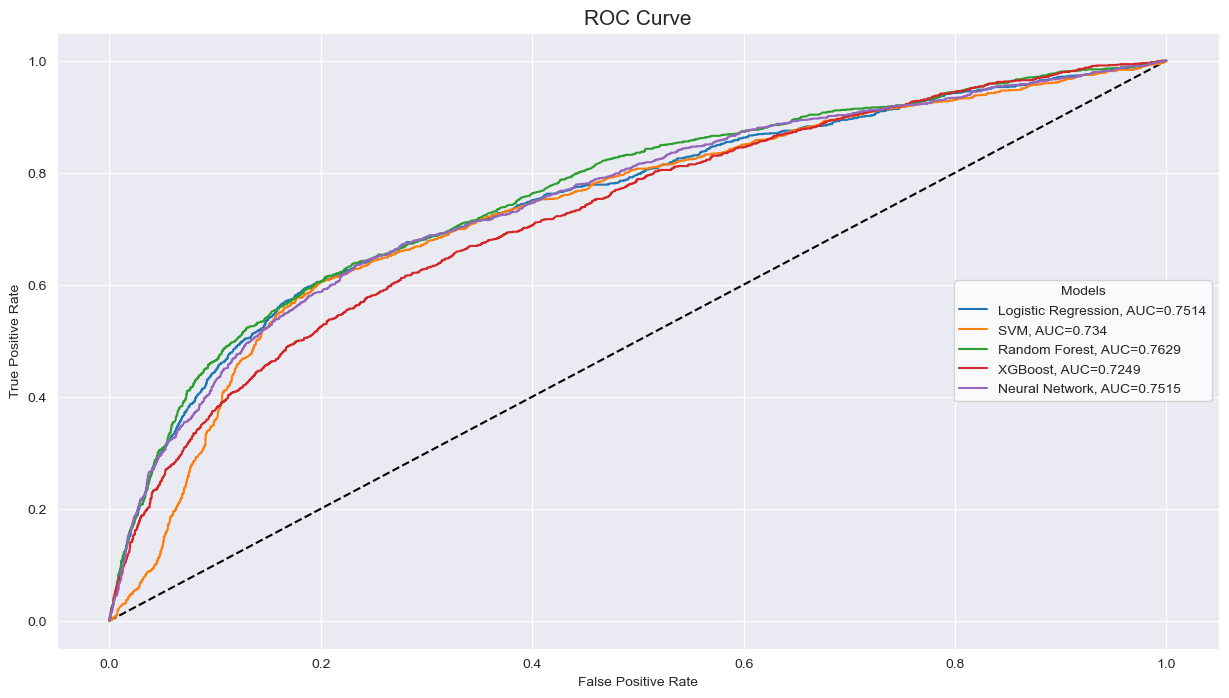

In [72]:
# Logistic Regression
lr_y_pred_proba = optimised_lr.predict_proba(X_test)[::,-1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_pred_proba)
lr_auc = roc_auc_score(y_test, lr_y_pred_proba)

# SVM
svm_y_pred_proba = optimised_svm.predict_proba(X_test)[::,1]
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_pred_proba)
svm_auc = roc_auc_score(y_test, svm_y_pred_proba)

# Random Forest
rf_y_pred_proba = optimised_rf.predict_proba(X_test)[::,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred_proba)
rf_auc = roc_auc_score(y_test, rf_y_pred_proba)

# XGBoost
xgb_y_pred_proba = optimised_xgboost.predict_proba(X_test)[::,1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred_proba)
xgb_auc = roc_auc_score(y_test, xgb_y_pred_proba)

# Neural Network
nn_y_pred_proba = optimised_nn.predict(X_test)[::,-1]
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_y_pred_proba)
nn_auc = roc_auc_score(y_test, nn_y_pred_proba)

# Plotting
plt.figure(figsize = (15, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression, AUC={round(lr_auc, 4)}")
plt.plot(svm_fpr, svm_tpr, label=f"SVM, AUC={round(svm_auc, 4)}")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest, AUC={round(rf_auc, 4)}")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost, AUC={round(xgb_auc, 4)}")
plt.plot(nn_fpr, nn_tpr, label=f"Neural Network, AUC={round(nn_auc, 4)}")
plt.legend(loc=5, title='Models', facecolor='white')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve', size=15)
plt.show()